# Research for Gym in Recife (Brazil)

TODO

# Problem

The SmartFit, the largest network of gyms in Latin America, planning to open a new unity in Recife, Brazil. 

They want to do a market analysis to know where are the best neighborhoods to put the new unity of SmartFit.

# Importing libs

In [1]:
import numpy as np
import pandas as pd
import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

#configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install geopandas
import geopandas as gpd

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

# Load the geo data from Recife


In [2]:
# geojon data provided by http://dados.recife.pe.gov.br/dataset/area-urbana
!wget -q -O 'recife.json' http://dados.recife.pe.gov.br/dataset/c1f100f0-f56f-4dd4-9dcc-1aa4da28798a/resource/e43bee60-9448-4d3d-92ff-2378bc3b5b00/download/bairros.geojson
    
with open('recife.json') as json_data:
    recife_data = json.load(json_data)

print("Loaded recife geojson")

gdf = gpd.GeoDataFrame.from_features(recife_data)
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y
gdf.crs = {'init' :'epsg:4326'}

gdf = gdf.sort_values('bairro_nome')
del gdf['bairro_nome_ca']
del gdf['microrregiao']

gdf.rename(columns={'bairro_codigo': 'neighborhood_code', 'bairro_nome': 'neighborhood'}, inplace=True)

gdf.head()

Loaded recife geojson


neighborhood_code          neighborhood  \
66                132               Aflitos   
90                779              Afogados   
59                540   Alto José Bonifácio   
75                523    Alto José do Pinho   
76                949  Alto Santa Terezinha   

                                             geometry  rpa  centroid_lon  \
66  POLYGON ((-34.8925588423082 -8.039902088598563...    3    -34.896325   
90  (POLYGON ((-34.91208929135482 -8.0640594534133...    5    -34.911484   
59  POLYGON ((-34.91126210759705 -8.00759817267291...    3    -34.912896   
75  POLYGON ((-34.91034752450803 -8.01863165508249...    3    -34.908407   
76  POLYGON ((-34.90508640139721 -8.01277658019323...    2    -34.908097   

    centroid_lat  
66     -8.040250  
90     -8.077604  
59     -8.013354  
75     -8.022161  
76     -8.015759

# Load the map of Recife 

In [3]:
address = 'Recife, Brazil'

geolocator = Nominatim(user_agent="dbln_explorer")
recife_location = geolocator.geocode(address)
recife_latitude = recife_location.latitude
recife_longitude = recife_location.longitude
print('The geograpical coordinate of Recife are {}, {}.'.format(recife_latitude, recife_longitude))

map_recife = folium.Map(location=[recife_latitude, recife_longitude], zoom_start=13)

map_recife

The geograpical coordinate of Recife are -8.0641931, -34.8781517.


# Create the functions to work with Foursquare API

In [4]:
CLIENT_ID = 'PKJSNBFVAVW3UIU4A3SLPM1UTUE4KG21VVKPFZVW0YG351IK' # your Foursquare ID
CLIENT_SECRET = 'NUSSSFL2C03ONKAA1ZFRHORT3VHKEVUMPWKLREANVYTWVBSM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500 # define radius
LIMIT = 100

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
 
        # make the GET request
        result = requests.get(url).json()["response"]
        if len(result) >  0:
            results = result['groups'][0]['items']
            venues_list.append([( name, lat, lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

# The the venues from the neighborhoods

In [5]:
recife_venues = getNearbyVenues(names=gdf['neighborhood'], latitudes=gdf['centroid_lat'], longitudes=gdf['centroid_lon'])

recife_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Aflitos               -8.04025              -34.896325   
1      Aflitos               -8.04025              -34.896325   
2      Aflitos               -8.04025              -34.896325   
3      Aflitos               -8.04025              -34.896325   
4      Aflitos               -8.04025              -34.896325   

                      Venue  Venue Latitude  Venue Longitude  \
0          China 48 Express       -8.041123       -34.894546   
1   Restaurante Ta San Yuen       -8.041105       -34.894456   
2            Empório Baiano       -8.038079       -34.895796   
3           Padaria Com.Pão       -8.041281       -34.898502   
4  Clube Náutico Capibaribe       -8.041406       -34.897634   

       Venue Category  
0  Chinese Restaurant  
1  Chinese Restaurant  
2                 Bar  
3              Bakery  
4        Soccer Field

# Load GYM venues

In [6]:
recife_gym_venues = recife_venues[recife_venues['Venue Category'].str.contains('Gym')]
recife_gym_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
29      Aflitos               -8.04025              -34.896325   
31      Aflitos               -8.04025              -34.896325   
37      Aflitos               -8.04025              -34.896325   
46      Aflitos               -8.04025              -34.896325   
63      Aflitos               -8.04025              -34.896325   

                                   Venue  Venue Latitude  Venue Longitude  \
29  Academia do The British Country Club       -8.038952       -34.898006   
31                       Ciafit Academia       -8.043493       -34.895280   
37                              Fit Club       -8.040329       -34.899703   
46                  Academia One Fitness       -8.043238       -34.899501   
63                  Corpore Sano Fitness       -8.038899       -34.896104   

          Venue Category  
29                   Gym  
31                   Gym  
37                   Gym  
46                   Gym  
63  Gym / Fitness Center

# Load Fitness Gym venues

In [7]:
recife_fitness_venues = recife_gym_venues[recife_gym_venues['Venue Category'].str.contains('Fitness')]
recife_fitness_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
63       Aflitos              -8.040250              -34.896325   
66       Aflitos              -8.040250              -34.896325   
106     Afogados              -8.077604              -34.911484   
116     Afogados              -8.077604              -34.911484   
201       Areias              -8.095114              -34.931702   

                                Venue  Venue Latitude  Venue Longitude  \
63               Corpore Sano Fitness       -8.038899       -34.896104   
66   Corpo e Movimento Studio Pilates       -8.040174       -34.892880   
106           Academia Beleza e Saúde       -8.080426       -34.909182   
116           Academia Master Fitness       -8.077572       -34.909122   
201                Fisiforma Academia       -8.098017       -34.931076   

           Venue Category  
63   Gym / Fitness Center  
66   Gym / Fitness Center  
106  Gym / Fitness Center  
116  Gym / Fitness Center  
201  Gym / Fitness Center

In [8]:
recife_gym_venues.shape

(159, 7)

In [9]:
recife_fitness_venues.shape

(55, 7)

In [20]:
recife_gym_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                 
Aflitos                                   6                       6      6   
Afogados                                  3                       3      3   
Alto José do Pinho                        1                       1      1   
Alto Santa Terezinha                      1                       1      1   
Alto do Mandu                             1                       1      1   
Areias                                    3                       3      3   
Arruda                                    1                       1      1   
Beberibe                                  3                       3      3   
Boa Viagem                                5                       5      5   
Boa Vista                                 1                       1      1   
Brejo de Beberibe                         1                       1      1   
Cajueiro                                  2                       2      2   
Campina do Barreto                        1                       1      1   
Campo Grande                              1                       1      1   
Casa Amarela                              3                       3      3   
Casa Forte                                3                       3      3   
Caçote                                    4                       4      4   
Coelhos                                   2                       2      2   
Cohab                                     2                       2      2   
Coqueiral                                 3                       3      3   
Cordeiro                                  3                       3      3   
Derby                                     1                       1      1   
Dois Unidos                               1                       1      1   
Encruzilhada                              3                       3      3   
Engenho do Meio                           1                       1      1   
Espinheiro                                5                       5      5   
Estância                                  3                       3      3   
Fundão                                    1                       1      1   
Graças                                    6                       6      6   
Hipódromo                                 4                       4      4   
Ilha do Leite                             4                       4      4   
Ilha do Retiro                            1                       1      1   
Ipsep                                     5                       5      5   
Iputinga                                  2                       2      2   
Jaqueira                                  1                       1      1   
Jardim São Paulo                          1                       1      1   
Jiquiá                                    1                       1      1   
Jordão                                    3                       3      3   
Linha do Tiro                             2                       2      2   
Macaxeira                                 1                       1      1   
Madalena                                  3                       3      3   
Mangueira                                 1                       1      1   
Monteiro                                  2                       2      2   
Mustardinha                               2                       2      2   
Paissandu                                 3                       3      3   
Parnamirim                                2                       2      2   
Peixinhos                                 1                       1      1   
Ponto de Parada                           4                       4      4   
Porto da Madeira                          1                       1      1   
Poço                                      4 

In [14]:
recife_fitness_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                              
Aflitos                                2                       2      2   
Afogados                               2                       2      2   
Areias                                 3                       3      3   
Boa Viagem                             2                       2      2   
Brejo de Beberibe                      1                       1      1   
Cajueiro                               1                       1      1   
Campo Grande                           1                       1      1   
Casa Amarela                           1                       1      1   
Casa Forte                             1                       1      1   
Caçote                                 2                       2      2   
Coelhos                                1                       1      1   
Coqueiral                              1                       1      1   
Derby                                  1                       1      1   
Dois Unidos                            1                       1      1   
Espinheiro                             2                       2      2   
Estância                               2                       2      2   
Ilha do Leite                          2                       2      2   
Ipsep                                  3                       3      3   
Iputinga                               2                       2      2   
Jiquiá                                 1                       1      1   
Jordão                                 3                       3      3   
Linha do Tiro                          1                       1      1   
Macaxeira                              1                       1      1   
Monteiro                               1                       1      1   
Paissandu                              1                       1      1   
Peixinhos                              1                       1      1   
Ponto de Parada                        1                       1      1   
Poço                                   1                       1      1   
Rosarinho                              1                       1      1   
Sancho                                 1                       1      1   
Santana                                1                       1      1   
Santo Amaro                            2                       2      2   
Tamarineira                            1                       1      1   
Tejipió                                1                       1      1   
Torre                                  2                       2      2   
Torreão                                1                       1      1   
Torrões                                1                       1      1   
Totó                                   1                       1      1   
Zumbi                                  1                       1      1   

                   Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                        
Aflitos                         2                2               2  
Afogados                        2                2               2  
Areias                          3                3               3  
Boa Viagem                      2                2               2  
Brejo de Beberibe               1                1               1  
Cajueiro                        1                1               1  
Campo Grande                    1                1               1  
Casa Amarela                    1                1               1  
Casa Forte                      1                1               1  
Caçote                          2                2               2  
Coelhos                         1                1               1  
Coqueiral                       1             

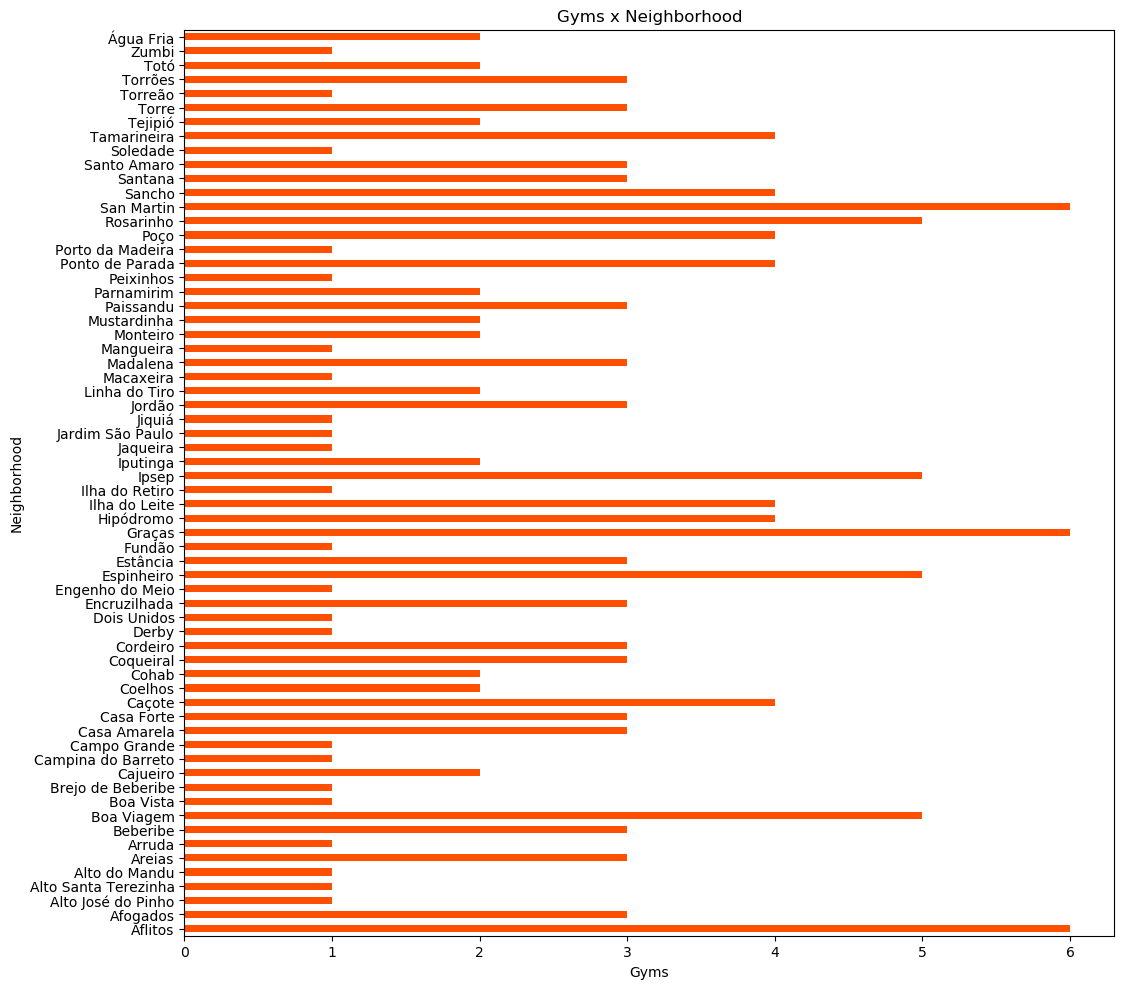

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

plt.figure(figsize=(12,12), dpi = 100)

plt.title('Gyms x Neighborhood')
plt.xlabel('Gyms')

recife_gym_venues.groupby('Neighborhood')['Venue Category'].count().plot(kind='barh', color='#ff4f00')

plt.show()

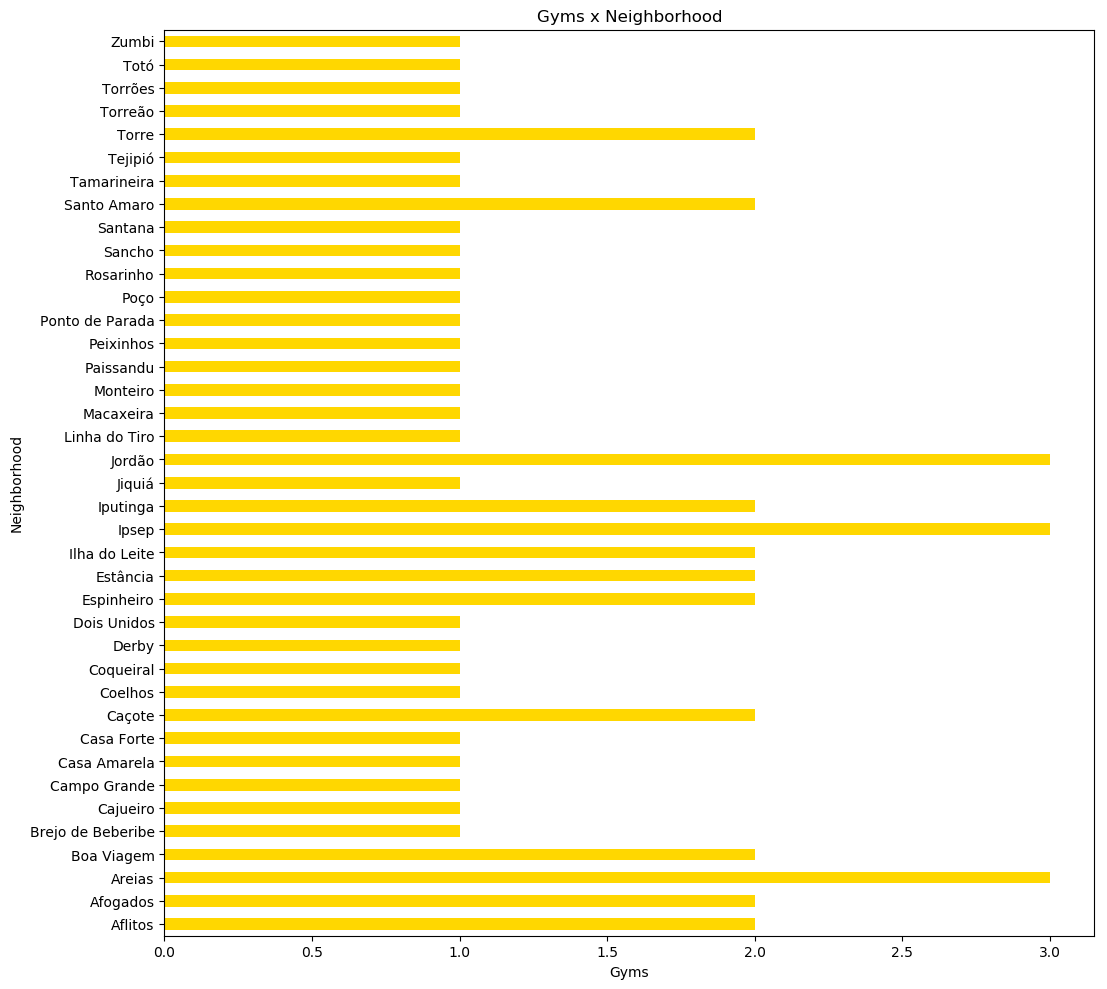

In [22]:
plt.figure(figsize=(12,12), dpi = 100)

plt.title('Gyms x Neighborhood')
plt.xlabel('Gyms')

recife_fitness_venues.groupby('Neighborhood')['Venue Category'].count().plot(kind='barh', color='#FFD700')

plt.show()

# Merge recife_gym_venues with 'gdf'

In [24]:
serie = recife_gym_venues.groupby('Neighborhood')['Venue Category'].count()
dataframe_groupby = pd.DataFrame({'neighborhood':serie.index, 'count':serie.values})

datagrame_merge_gym = gdf.merge(dataframe_groupby, on='neighborhood')
datagrame_merge_gym.head()

neighborhood_code          neighborhood  \
0                132               Aflitos   
1                779              Afogados   
2                523    Alto José do Pinho   
3                949  Alto Santa Terezinha   
4                493         Alto do Mandu   

                                            geometry  rpa  centroid_lon  \
0  POLYGON ((-34.8925588423082 -8.039902088598563...    3    -34.896325   
1  (POLYGON ((-34.91208929135482 -8.0640594534133...    5    -34.911484   
2  POLYGON ((-34.91034752450803 -8.01863165508249...    3    -34.908407   
3  POLYGON ((-34.90508640139721 -8.01277658019323...    2    -34.908097   
4  POLYGON ((-34.92782185721514 -8.01876640643194...    3    -34.927936   

   centroid_lat  count  
0     -8.040250      6  
1     -8.077604      3  
2     -8.022161      1  
3     -8.015759      1  
4     -8.021916      1

# Merge recife_fitness_venues with 'gdf'

In [31]:
serie = recife_fitness_venues.groupby('Neighborhood')['Venue Category'].count()
dataframe_groupby = pd.DataFrame({'neighborhood':serie.index, 'count':serie.values})

datagrame_merge_fitness = gdf.merge(dataframe_groupby, on='neighborhood')
datagrame_merge_fitness.head()


neighborhood_code       neighborhood  \
0                132            Aflitos   
1                779           Afogados   
2                850             Areias   
3                205         Boa Viagem   
4                574  Brejo de Beberibe   

                                            geometry  rpa  centroid_lon  \
0  POLYGON ((-34.8925588423082 -8.039902088598563...    3    -34.896325   
1  (POLYGON ((-34.91208929135482 -8.0640594534133...    5    -34.911484   
2  POLYGON ((-34.92534411302587 -8.09271014943841...    5    -34.931702   
3  POLYGON ((-34.90789748496555 -8.15534022816226...    6    -34.902890   
4  POLYGON ((-34.92952514601965 -7.98825822997313...    3    -34.923294   

   centroid_lat  count  
0     -8.040250      2  
1     -8.077604      2  
2     -8.095114      3  
3     -8.128004      2  
4     -7.998455      1

In [33]:
map_recife = folium.Map(location=[np.median(datagrame_merge_gym['centroid_lat'].tolist()), np.median(datagrame_merge_gym['centroid_lon'].tolist())], zoom_start=12)

map_recife.choropleth(
    geo_data=recife_data,
    name='Bairros do Recife',
    data=datagrame_merge_gym,
    columns=['neighborhood', 'count'],
    key_on='properties.bairro_nome',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Venues'
)

map_recife

In [32]:
map_recife = folium.Map(location=[np.median(datagrame_merge_fitness['centroid_lat'].tolist()), np.median(datagrame_merge_fitness['centroid_lon'].tolist())], zoom_start=12)

map_recife.choropleth(
    geo_data=recife_data,
    name='Bairros do Recife',
    data=datagrame_merge_fitness,
    columns=['neighborhood', 'count'],
    key_on='properties.bairro_nome',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Venues'
)

map_recife

# Neighborhoods with 3 or more gym but without fitness

In [35]:
dataframe_result = datagrame_merge_gym.merge(datagrame_merge_fitness,on=['neighborhood_code'],how='left')
dataframe_result = dataframe_result[dataframe_result['count_x'] >= 3]
dataframe_result.head()

neighborhood_code neighborhood_x  \
0                132        Aflitos   
1                779       Afogados   
5                850         Areias   
7                370       Beberibe   
8                205     Boa Viagem   

                                          geometry_x  rpa_x  centroid_lon_x  \
0  POLYGON ((-34.8925588423082 -8.039902088598563...      3      -34.896325   
1  (POLYGON ((-34.91208929135482 -8.0640594534133...      5      -34.911484   
5  POLYGON ((-34.92534411302587 -8.09271014943841...      5      -34.931702   
7  POLYGON ((-34.89168753723165 -8.00352386281026...      2      -34.896460   
8  POLYGON ((-34.90789748496555 -8.15534022816226...      6      -34.902890   

   centroid_lat_x  count_x neighborhood_y  \
0       -8.040250        6        Aflitos   
1       -8.077604        3       Afogados   
5       -8.095114        3         Areias   
7       -8.005285        3            NaN   
8       -8.128004        5     Boa Viagem   

                                          geometry_y  rpa_y  centroid_lon_y  \
0  POLYGON ((-34.8925588423082 -8.039902088598563...    3.0      -34.896325   
1  (POLYGON ((-34.91208929135482 -8.0640594534133...    5.0      -34.911484   
5  POLYGON ((-34.92534411302587 -8.09271014943841...    5.0      -34.931702   
7                                                NaN    NaN             NaN   
8  POLYGON ((-34.90789748496555 -8.15534022816226...    6.0      -34.902890   

   centroid_lat_y  count_y  
0       -8.040250      2.0  
1       -8.077604      2.0  
5       -8.095114      3.0  
7             NaN      NaN  
8       -8.128004      2.0

# Final result

In [36]:
map_recife = folium.Map(location=[np.median(dataframe_result['centroid_lat_x'].tolist()), np.median(dataframe_result['centroid_lon_x'].tolist())], zoom_start=12)

map_recife.choropleth(
    geo_data=recife_data,
    name='Bairros do Recife',
    data=dataframe_result,
    columns=['neighborhood_x', 'count_x'],
    key_on='properties.bairro_nome',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Venues'
)

map_recife